In [547]:
type(np.random.rand(n))

numpy.ndarray

In [574]:
from scipy.optimize import SR1, BFGS
import numpy as np
import scipy as sp

def generate_matrix_with_spectrum(spectrum):
    size = len(spectrum)
    Q, _ = np.linalg.qr(np.random.randn(size, size))
    D = np.diag(spectrum)
    A = Q @ D @ Q.T
    return A


def func(x):
    return x.T @ A @ x

def grad(x):
    return (A + A.T) @ x

def svd(U, S, VT, k):
    rank_one_approx = S[k] * np.outer(U[:, k], VT[k, :])
    return rank_one_approx

def nystrom_approximation(A, k):
    n = A.shape[0]
    omega = np.random.rand(n, k) + 10*np.ones((n, k))
    Y = A @ omega
    approx = Y @ np.linalg.inv(omega.T @ Y) @ Y.T
    return approx

def nystrom_approximation(A, x0, gradient, max_iter):
    x = x0
    n = len(x0)
    H = np.eye(n)
    Hks = []
    omega = np.nan
    for _ in range(max_iter):
        grad = gradient(x)            
        p = -np.dot(np.linalg.inv(H), grad)
        # alpha = backtracking_line_search(objective_function, grad, x, p)
        alpha = 1.
        x_new = x + alpha * p
        # print(alpha)
        s = x_new - x
        y = gradient(x_new) - grad
        if type(omega) == float:
            omega = np.expand_dims(s, axis=1)
        else:
            omega = np.concatenate((omega, np.expand_dims(s, axis=1)), axis=1)
        Y = A @ omega
        H = Y @ np.linalg.inv(omega.T @ Y) @ Y.T

        x = x_new
        Hks += [H]
    return Hks

def wolfe_conditions(f, gradient, alpha, x, p, c1=1e-2, c2=0.9):
    phi = f(x)
    phi_alpha = f(x + alpha * p)
    if phi_alpha > phi + c1 * alpha * np.dot(gradient, p):
        return False
    if np.dot(grad(x + alpha * p), p) < c2 * np.dot(gradient, p):
        return False 
    return True

def backtracking_line_search(f, grad, x, p, alpha=1.0, beta=0.5):
    it = 0
    while not wolfe_conditions(f, grad, alpha, x, p) and it < 100:
        alpha *= beta
        it += 1
    return alpha

def bfgs_method(objective_function, x0, gradient, max_iter=100):
    x = x0
    n = len(x0)
    H = np.eye(n)
    Hks = []
    for _ in range(max_iter):
        grad = gradient(x)            
        p = -np.dot(H, grad)
        # alpha = backtracking_line_search(objective_function, grad, x, p)
        alpha = 1.
        x_new = x + alpha * p
        # print(alpha)
        s = x_new - x
        y = gradient(x_new) - grad
        rho = 1.0 / np.dot(y, s)
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)

        x = x_new
        Hks += [np.linalg.inv(H)]
    return Hks

def sr1(x0, gradient, max_iter=100):
    x = x0
    n = len(x0)
    H = np.eye(n)
    Hks = []
    for _ in range(max_iter):
        grad = gradient(x)            
        p = -np.dot(H, grad)
        alpha = max(backtracking_line_search(objective_function, grad, x, p), 0.1)
        # print(alpha)
        # alpha = 1.
        x_new = x + alpha * p
        s = x_new - x
        y = gradient(x_new) - grad
        H += np.outer(s - H@y, s - H@y) / np.dot(s - H@y, y)
        x = x_new
        Hks += [np.linalg.inv(H)]
    return Hks

def broyden_method(f, x0, max_iter=100):
    x = x0
    n = len(x0)
    B = np.eye(n)
    Hks = []
    for i in range(max_iter):
        fx = f(x)
        delta = np.linalg.solve(B, -fx)
        x_new = x + delta
        fx_new = f(x_new)
        s = x_new - x
        y = fx_new - fx
        Bs = B @ s
        B += (y - Bs).reshape(-1, 1) @ s.reshape(1, -1) / (s.T @ s)
        Hks += [B.copy()]
        x = x_new
    return Hks

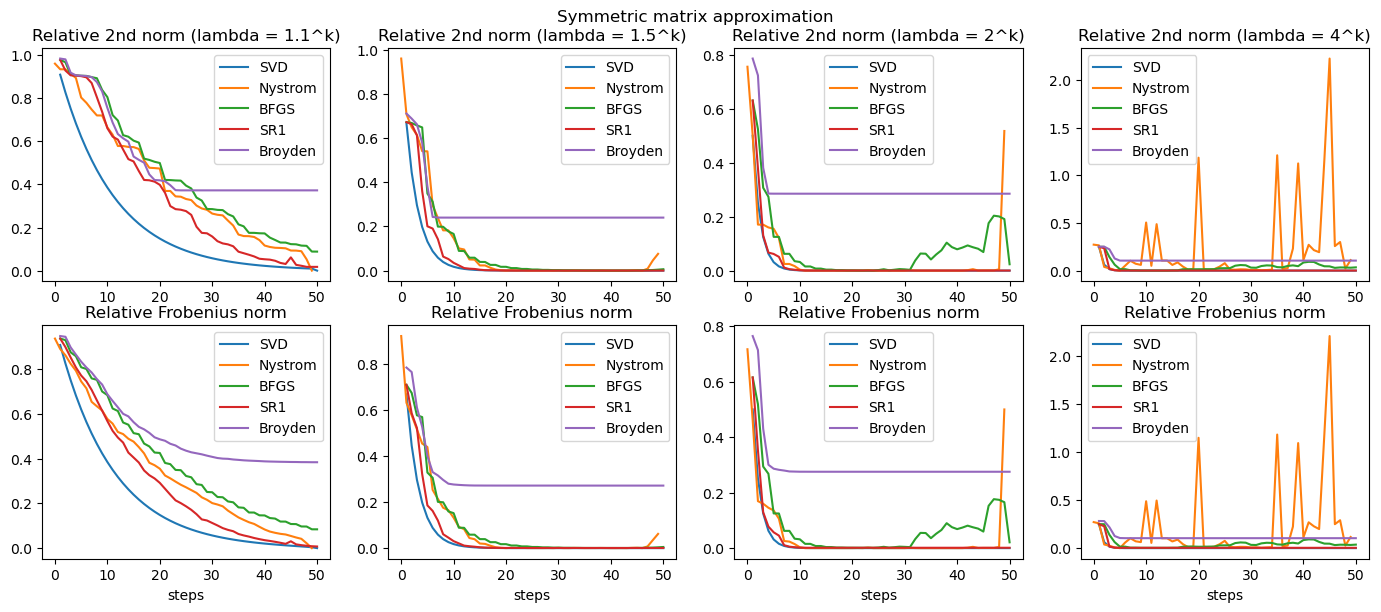

In [610]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy as sp


cut = lambda x : x if abs(x) < 4000 else 0
n = 50
spectrums = [
    [cut(1.1**k) for k in range(n)],
    [cut(1.5**k) for k in range(n)],
    [cut(2.0**k) for k in range(n)],
    [cut(4.0**k) for k in range(n)]
]
names = [
    'lambda = 1.1^k',
    'lambda = 1.5^k',
    'lambda = 2^k',
    'lambda = 4^k'
]
f, (ax1, ax2) = plt.subplots(2, len(spectrums), figsize=(14, 6))
f.suptitle('Symmetric matrix approximation')
f.tight_layout()

for (i, spectrum), name in zip(enumerate(spectrums), names):
    A = generate_matrix_with_spectrum(spectrum)
    # A = A@A.T
    # A = A + A.T
    approx_matrix = np.zeros((n, n))
    svd_frobs = []
    svd_secs = []
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    for k in range(n):
        approx_matrix += svd(U, S, VT, k)
        svd_frobs += [np.linalg.norm((approx_matrix - (A)), ord='fro') / np.linalg.norm((A), ord='fro')]
        svd_secs += [np.linalg.norm((approx_matrix - (A)), ord=2) / np.linalg.norm((A), ord=2)]


    x0 = np.random.rand(n)
    nystrom_frobs = []
    nystrom_secs = []
    Hks = nystrom_approximation(A+A.T, x0, grad, n)
    for H in Hks:
        nystrom_frobs += [np.linalg.norm((H - (A+A.T)), ord='fro') / np.linalg.norm((A+A.T), ord='fro')]
        nystrom_secs += [np.linalg.norm((H - (A+A.T)), ord=2) / np.linalg.norm((A+A.T), ord=2)]


    x0 = np.random.rand(n)
    bfgs_frobs = []
    bfgs_secs = []
    Hks = bfgs_method(func, x0, grad, n)
    for H in Hks:
        bfgs_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        bfgs_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]

    sr1_frobs = []
    sr1_secs = []
    Hks = sr1(x0, grad, n)
    for H in Hks:
        sr1_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        sr1_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]

    broyden_frobs = []
    broyden_secs = []
    Hks = broyden_method(grad, x0, n)
    for H in Hks:
        broyden_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        broyden_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]


    steps = range(1, n+1)
    ax1[i].plot(steps, svd_secs, label='SVD')
    ax1[i].plot(nystrom_secs, label='Nystrom')
    ax1[i].plot(steps, bfgs_secs, label='BFGS')
    ax1[i].plot(steps, sr1_secs, label='SR1')
    ax1[i].plot(steps, broyden_secs, label='Broyden')
    ax1[i].set_title(f'Relative 2nd norm ({name})')
    ax1[i].legend()

    ax2[i].plot(steps, svd_frobs, label='SVD')
    ax2[i].plot(nystrom_frobs, label='Nystrom')
    ax2[i].plot(steps,bfgs_frobs, label='BFGS')
    ax2[i].plot(steps, sr1_frobs, label='SR1')
    ax2[i].plot(steps, broyden_frobs, label='Broyden')
    ax2[i].set_title('Relative Frobenius norm')
    ax2[i].set_xlabel('steps')
    ax2[i].legend()

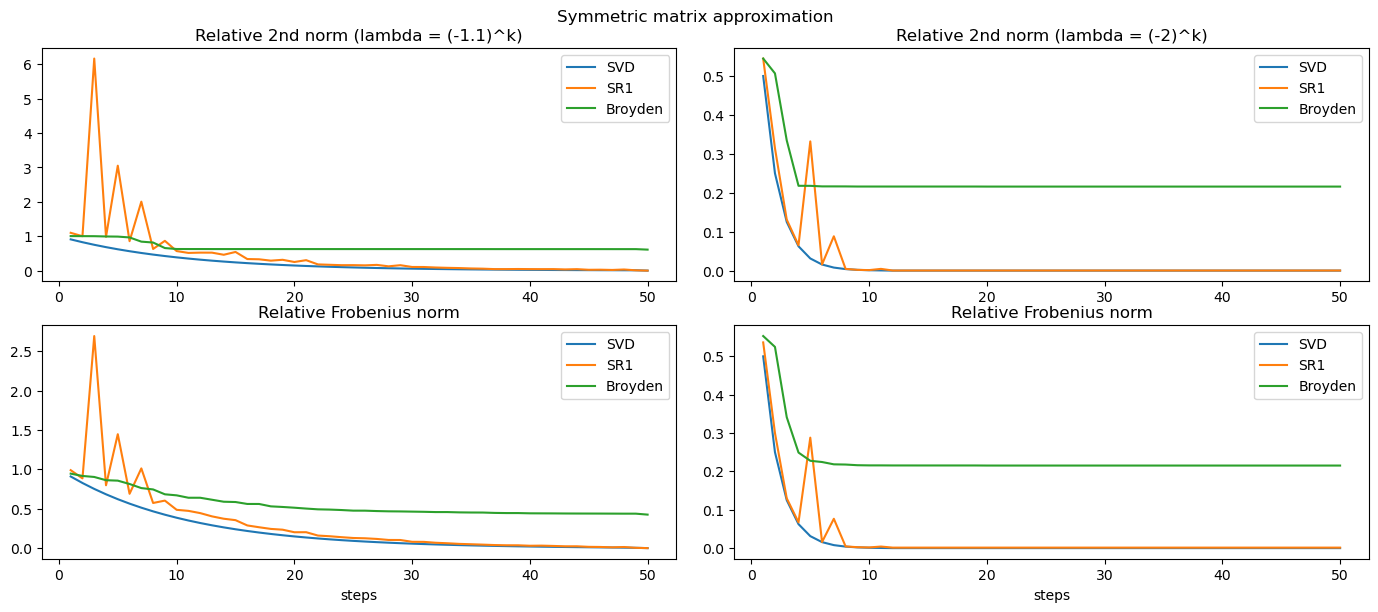

In [596]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy as sp


n = 50
spectrums = [
    [(-1.1)**k for k in range(n)],
    [cut((-2)**k) for k in range(n)],
]
names = [
    'lambda = (-1.1)^k',
    'lambda = (-2)^k',
]
f, (ax1, ax2) = plt.subplots(2, len(spectrums), figsize=(14, 6))
f.suptitle('Symmetric matrix approximation')
f.tight_layout()

for (i, spectrum), name in zip(enumerate(spectrums), names):
    A = generate_matrix_with_spectrum(spectrum)
    # A = A@A.T
    # A = A + A.T
    approx_matrix = np.zeros((n, n))
    svd_frobs = []
    svd_secs = []
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    for k in range(n):
        approx_matrix += svd(U, S, VT, k)
        svd_frobs += [np.linalg.norm((approx_matrix - (A)), ord='fro') / np.linalg.norm((A), ord='fro')]
        svd_secs += [np.linalg.norm((approx_matrix - (A)), ord=2) / np.linalg.norm((A), ord=2)]


    x0 = np.random.rand(n)
    nystrom_frobs = []
    nystrom_secs = []
    Hks = nystrom_approximation(A+A.T, x0, grad, n)
    for H in Hks:
        nystrom_frobs += [np.linalg.norm((H - (A+A.T)), ord='fro') / np.linalg.norm((A+A.T), ord='fro')]
        nystrom_secs += [np.linalg.norm((H - (A+A.T)), ord=2) / np.linalg.norm((A+A.T), ord=2)]


    x0 = np.random.rand(n)
    bfgs_frobs = []
    bfgs_secs = []
    Hks = bfgs_method(func, x0, grad, n)
    for H in Hks:
        bfgs_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        bfgs_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]

    sr1_frobs = []
    sr1_secs = []
    Hks = sr1(x0, grad, n)
    for H in Hks:
        sr1_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        sr1_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]

    broyden_frobs = []
    broyden_secs = []
    Hks = broyden_method(grad, x0, n)
    for H in Hks:
        broyden_frobs += [np.linalg.norm((H - A - A.T), ord='fro') / np.linalg.norm((A + A.T), ord='fro')]
        broyden_secs += [np.linalg.norm((H - A - A.T), ord=2) / np.linalg.norm((A + A.T), ord=2)]


    steps = range(1, n+1)
    ax1[i].plot(steps, svd_secs, label='SVD')
    # ax1[i].plot(nystrom_secs, label='Nystrom')
    # ax1[i].plot(steps, bfgs_secs, label='BFGS')
    ax1[i].plot(steps, sr1_secs, label='SR1')
    ax1[i].plot(steps, broyden_secs, label='Broyden')
    ax1[i].set_title(f'Relative 2nd norm ({name})')
    ax1[i].legend()

    ax2[i].plot(steps, svd_frobs, label='SVD')
    # ax2[i].plot(nystrom_frobs, label='Nystrom')
    # ax2[i].plot(steps,bfgs_frobs, label='BFGS')
    ax2[i].plot(steps, sr1_frobs, label='SR1')
    ax2[i].plot(steps, broyden_frobs, label='Broyden')
    ax2[i].set_title('Relative Frobenius norm')
    ax2[i].set_xlabel('steps')
    ax2[i].legend()

Combinations of yyT syT ysT ssT